In [1]:
import numpy as np
import numpy as np
import subprocess
import time
import copy
from utils.opt_utils import *
import os
import h5py
import pickle
from qutip import *
import utils.pulse_configs as pc
import time

In [2]:
config_dict = pc.config_dict

In [3]:
# Defining relevant values
q_ch = config_dict["qubit"]["ch"] 
A_ch = config_dict["storage_A"]["ch"]
B_ch = config_dict["storage_B"]["ch"]

wq = config_dict["qubit"]["selective_freqs"]["g"]["ge"]
wa_A = config_dict["storage_A"]["freq"]
wa_B = config_dict["storage_B"]["freq"]

In [4]:
# ========== OPTIONS ========== #
max_segs = 20
time_start = 0.0000000
time_stop = 0.000001
init_amp = 1000

num_drives = 2
chs = [2, 4]
init_freqs = [wq, wa_A]
verbose = True
plot_opt_pulses = False
plot_pulse_viewer = False
start_split_num = 1
n_seg_jump = 1

save_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\ctrl_vqe_state_prep_g2_interp\save_data'
hdf5_name = time.strftime('%Y%m%d-%H%M%S.h5') # os.path.join(save_dir, 
epochs = 50
epochs_per_seg = 50
train_batch_size = 20
qubit_amp_scale = 4
cavity_amp_scale = 4
freq_scale = 0.001
# ========== OPTIONS ========== #

drive_freqs = np.array(init_freqs)

qscale = []
cscale = []
for i in range(2):
    qscale.append(init_amp * qubit_amp_scale)
    cscale.append(init_amp * cavity_amp_scale)

t_segs, amp_segs = setup_interp_segs(2 * num_drives, time_start, time_stop, init_amp)

amp_segs[:2, :] = 1000

print(f't_segs: {amp_segs}')

for i in range(start_split_num - 1):
    t_segs, amp_segs = split_segs_flat(interp_time_wrapper(t_segs, time_start, time_stop), interp_amp_wrapper(amp_segs))
    # amp_segs = amp_segs[:, 1:-1]
    
# trial_amp_segs = copy.deepcopy(amp_segs[:, 1:-1])

# Create blank history arrays for storing optimal / past values
time_hist = []
amp_hist = []
freq_hist = []
cost_hist = []

[1.44412274e-07]
[2.11634544e-07]
[4.03274389e-07]
[3.20274669e-07]
t_segs: [[1000]
 [1000]
 [1000]
 [1000]]


In [5]:
# Run vqe, etc
vmax = np.vectorize(max)
vmin = np.vectorize(min)

hdf5_start_index = 0
start_segs = 1
for i in range(max_segs):
    temp_amp_scale = copy.deepcopy(amp_segs)
    temp_time_scale = copy.deepcopy(t_segs[:, 1:-1])
    if np.shape(temp_amp_scale)[0] < 2:
        temp_amp_scale[:, :] = vmax(np.abs(amp_segs * qubit_amp_scale), init_amp * np.ones(np.shape(amp_segs)) / qubit_amp_scale)
    else:
        temp_amp_scale[:2, :] = vmax(np.abs(amp_segs[:2] * qubit_amp_scale), init_amp * np.ones(np.shape(amp_segs[:2])) / qubit_amp_scale)
        temp_amp_scale[2:, :] = vmax(np.abs(amp_segs[2:] * cavity_amp_scale), init_amp * np.ones(np.shape(amp_segs[2:])) / cavity_amp_scale)
    
    temp_time_scale = vmin(t_segs[:, 1:-1] - time_start, time_stop - t_segs[:, 1:-1])
    
    temp_freq_scale = list(freq_scale * np.array(drive_freqs))

    client_args = [chs, verbose, plot_opt_pulses, plot_pulse_viewer, time_start, time_stop]
    server_args = [(len(t_segs[0]) - 2) * epochs_per_seg, train_batch_size, amp_segs, t_segs[:, 1:-1], drive_freqs, temp_amp_scale, temp_time_scale, temp_freq_scale, hdf5_name]

        
    # Save args for rl client
    cf_name = "temp_files/client_args.txt"
    with open(cf_name, "wb") as fp:
        pickle.dump(client_args, fp)
    fp.close()
    
    # Save args for rl server
    sf_name = "temp_files/server_args.txt"
    with open(sf_name, "wb") as fp:
        pickle.dump(server_args, fp)
    fp.close()
    

    os.system('cmd /c python ./exp_ctrl_vqe_run_rl_scripts.py') 
    
    # Give time for files to be updated etc
    time.sleep(1)
    
    time.sleep(10)
    opt_amps = []
    opt_times = []
    opt_freqs = []
    with h5py.File(os.path.join(save_dir, hdf5_name), "r") as f:
        opt_res_index = np.argmax(f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()])
        opt_result = f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()][opt_res_index]
        for j in range(2 * num_drives):
            opt_amps.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'pulse_array_{j}'][()][opt_res_index]])
        for j in range(2 * num_drives):
            opt_times.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'time_array_{j}'][()][opt_res_index]])
        for j in range(num_drives):
            opt_freqs.append(f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'freq_{j}'][()][opt_res_index])
    
    # updates amplitudes and frequencies with optimized values and reshape
    amp_segs = np.array(opt_amps)
    amp_segs = np.reshape(amp_segs, (num_drives * 2, int(len(amp_segs.flatten()) / (num_drives * 2))))
    
    t_segs = np.array(opt_times)
    t_segs = np.reshape(t_segs, (num_drives * 2, int(len(amp_segs.flatten()) / (num_drives * 2))))
    
    print(f'================')
    print(f'num segs: {i + start_segs} ')
    print(f'opt_amps: {amp_segs}')
    print(f'opt_times: {t_segs}')
    print(f'opt_freqs: {opt_freqs}')
    print(f'opt_result: {opt_result}')

    # save values to history arrays
    time_hist.append(interp_time_wrapper(t_segs, time_start, time_stop))
    amp_hist.append(interp_amp_wrapper(amp_segs))
    freq_hist.append(drive_freqs)
    cost_hist.append(opt_result)
    
    np.savez(r'run_data\\' + hdf5_name[:-3] + "-" + str(i) + ".npz", time=time_hist[-1], amp=amp_hist[-1], freq=freq_hist[-1], cost=cost_hist[-1])
    
    # # Save time history
    # with h5py.File(hdf5_name, 'w'):
    #     

    for i in range(2 * n_seg_jump):
        qscale.append(init_amp * qubit_amp_scale)
        cscale.append(init_amp * cavity_amp_scale)
 
    # split segments and return to start of loop
    if (i < max_segs - 1):
        for i in range(n_seg_jump):
            t_segs, amp_segs = split_segs_flat(interp_time_wrapper(t_segs, time_start, time_stop), interp_amp_wrapper(amp_segs))

KeyboardInterrupt: 

In [10]:
f = np.load(r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\ctrl_vqe_state_prep_interp\run_data\20241001-183559-4.npz')
l_times = f['time']
l_amp = f['amp']
l_freq = f['freq']
l_cost = f['cost']

In [11]:
client_args = [chs, verbose, plot_opt_pulses, plot_pulse_viewer, time_start, time_stop]
l_t_segs = l_times[:, 1:-1]
l_amp_segs = l_amp[:, 1:-1]

In [12]:
plot_input = np.append(np.append(l_amp_segs.flatten(), l_t_segs.flatten()), l_freq)

0.0
0.0
0.0
0.0
0.0
0.0


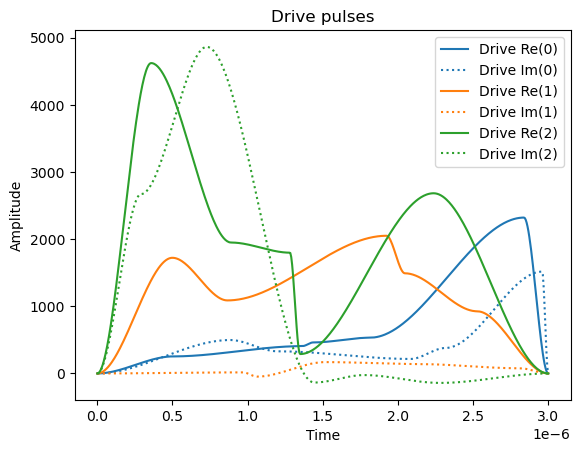

In [13]:
exp_interp_shape_plot(np.append(np.append(l_amp_segs.flatten(), l_t_segs.flatten()), l_freq), *client_args)


ind: 0
<class 'int'>
ind: 1
<class 'int'>
ind: 2
<class 'int'>
ind: 3
<class 'int'>
ind: 4
<class 'int'>
ind: 4
<class 'int'>
C:/_Data/images/20241003/024321_pulse-seq has been saved.


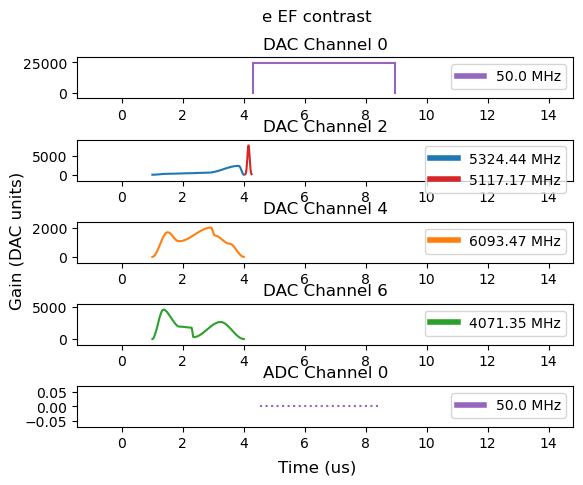



ind: 0
<class 'int'>
ind: 1
<class 'int'>
ind: 2
<class 'int'>
ind: 3
<class 'int'>
ind: 4
<class 'int'>
ind: 5
<class 'int'>
ind: 5
<class 'int'>
C:/_Data/images/20241003/024322_pulse-seq has been saved.


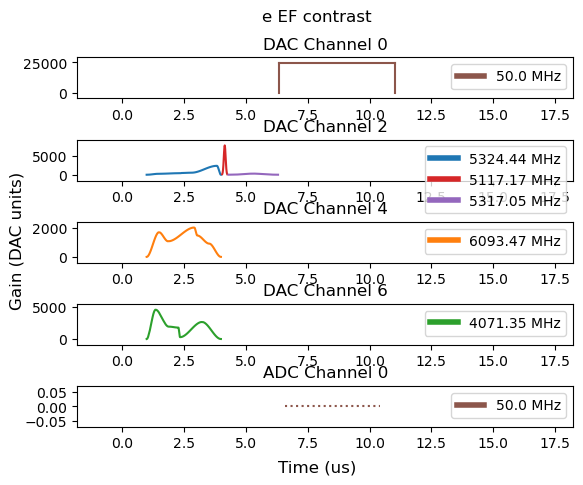

In [14]:
exp_interp_pulse_plot(np.append(np.append(l_amp_segs.flatten(), l_t_segs.flatten()), l_freq), *client_args)

In [7]:
print(f.__dict__.keys())
f['time']
f['amp']
f['freq']

dict_keys(['_files', 'files', 'allow_pickle', 'pickle_kwargs', 'zip', 'f', 'fid'])


array([5324.437, 6093.469, 4071.354])